#### 데이터 불러오기

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, RocCurveDisplay, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
comp=pd.read_csv('comp.csv',encoding='cp949')

In [4]:
X = comp.drop('Intention to move into public rental housing', axis = 1)
y = comp[['Intention to move into public rental housing']]

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [6]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.25, random_state=0)

In [7]:
X_train.shape, X_valid.shape, X_test.shape

((28077, 126), (9359, 126), (9360, 126))

In [8]:
X_train.shape[0]/X.shape[0], X_valid.shape[0]/X.shape[0], X_test.shape[0]/X.shape[0]

(0.5999871783913155, 0.1999957261304385, 0.200017095478246)

#### pycaret

In [8]:
from pycaret.classification import *

In [13]:
train_data = pd.concat([X_train, y_train], axis=1) # 훈련 데이터 합치기
valid_data = pd.concat([X_valid, y_valid], axis=1) # 검층 데이터 합치기

In [18]:
clf = setup(data=train_data,
            test_data = valid_data,
           target='Intention to move into public rental housing',  # y 컬럼명
           session_id=123,  # 재현성을 위한 시드 설정
           fold=10)  # 교차 검증 폴드 수

,Description,Value
0,Session id,123
1,Target,Intention to move into public rental housing
2,Target type,Binary
3,Original data shape,"(37436, 127)"
4,Transformed data shape,"(37436, 127)"
5,Transformed train set shape,"(28077, 127)"
6,Transformed test set shape,"(9359, 127)"
7,Numeric features,126
8,Preprocess,True
9,Imputation type,simple


In [19]:
# 여러 모델 비교
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8000,0.8501,0.6092,0.7205,0.6600,0.5198,0.5236,0.5880
rf,Random Forest Classifier,0.7992,0.8493,0.5969,0.7248,0.6545,0.5149,0.5198,1.1090
et,Extra Trees Classifier,0.7987,0.8470,0.6016,0.7209,0.6557,0.5152,0.5195,1.4910
xgboost,Extreme Gradient Boosting,0.7984,0.8460,0.6163,0.7124,0.6607,0.5184,0.5213,0.3420
gbc,Gradient Boosting Classifier,0.7979,0.8413,0.6154,0.7117,0.6599,0.5173,0.5202,1.6710
lr,Logistic Regression,0.7920,0.8335,0.5866,0.7105,0.6425,0.4977,0.5024,2.6150
ridge,Ridge Classifier,0.7911,0.8319,0.5937,0.7047,0.6444,0.4981,0.5018,0.0970
ada,Ada Boost Classifier,0.7911,0.8322,0.5964,0.7034,0.6453,0.4987,0.5023,0.6860
lda,Linear Discriminant Analysis,0.7908,0.8319,0.6072,0.6974,0.6490,0.5010,0.5035,0.2330
knn,K Neighbors Classifier,0.7700,0.7750,0.5193,0.6833,0.5900,0.4343,0.4423,0.3590


In [20]:
# 최적 모델 선택 및 학습
final_model = create_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8038,0.8561,0.6480,0.7108,0.6780,0.5373,0.5385
1,0.8056,0.8505,0.6123,0.7336,0.6675,0.5317,0.5360
2,0.7977,0.8417,0.5933,0.7224,0.6515,0.5110,0.5159
3,0.8009,0.8545,0.6022,0.7264,0.6585,0.5198,0.5243
4,0.7974,0.8462,0.6045,0.7156,0.6554,0.5133,0.5170
5,0.8024,0.8559,0.6112,0.7255,0.6634,0.5250,0.5288
6,0.7974,0.8488,0.5978,0.7191,0.6528,0.5115,0.5158
7,0.7962,0.8536,0.6078,0.7111,0.6554,0.5120,0.5152
8,0.8051,0.8571,0.6235,0.7266,0.6711,0.5338,0.5369


In [21]:
# 모델 튜닝
tuned_model = tune_model(final_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8045,0.8539,0.6559,0.7089,0.6814,0.5407,0.5415
1,0.8041,0.8486,0.6168,0.7273,0.6675,0.5300,0.5336
2,0.7956,0.8378,0.5877,0.7196,0.6470,0.5052,0.5103
3,0.7977,0.8469,0.6056,0.7160,0.6562,0.5143,0.5179
4,0.7981,0.8388,0.6190,0.7103,0.6615,0.5186,0.5211
5,0.8038,0.8554,0.6279,0.7205,0.6710,0.5322,0.5347
6,0.8038,0.8469,0.6022,0.7343,0.6618,0.5255,0.5306
7,0.7962,0.8484,0.6034,0.7133,0.6538,0.5108,0.5144
8,0.8023,0.8533,0.6257,0.7179,0.6687,0.5287,0.5312


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


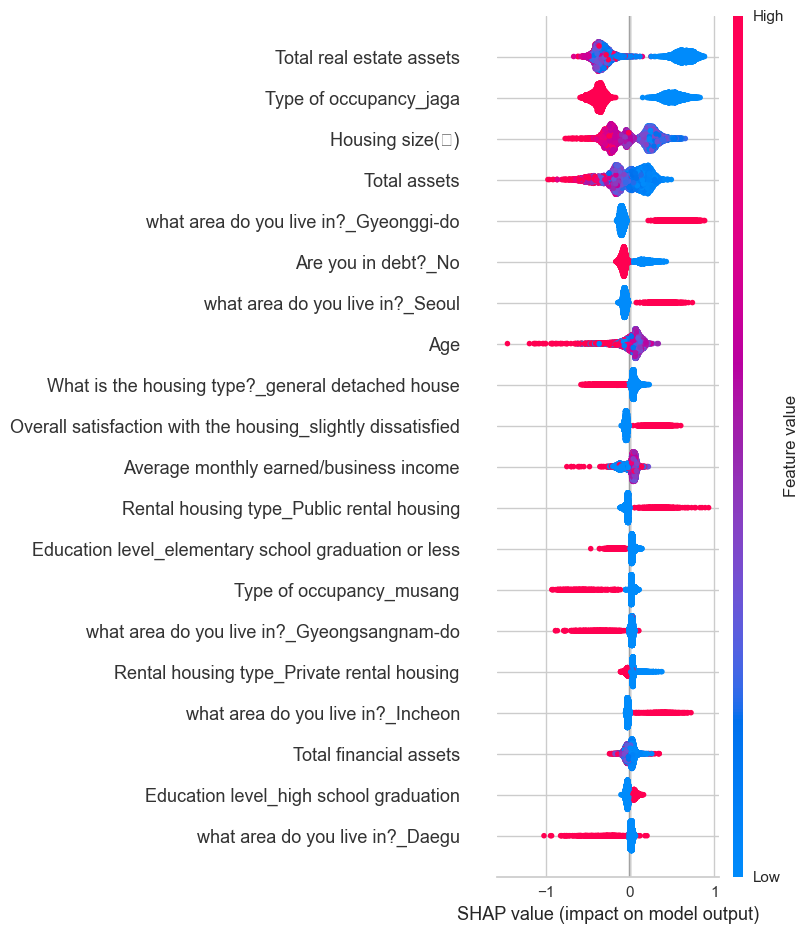

In [22]:
interpret_model(tuned_model, plot='summary')

In [23]:
tuned_model

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

In [24]:
save_model(tuned_model, 'pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['Length of residence',
                                              'Housing size(㎡)', 'Age',
                                              'Number of household members',
                                              'Average monthly earned/business '
                                              'income',
                                              'Average monthly Property income',
                                              'Average monthly social insurance '
                                              'benefits',
                                              'Average monthly government '
                                              'subsidies',
                                              'Average monthly private...
                  LGBMClassifier(boosting_type='gbdt', class_weight=None,
           

In [9]:
lgbm_model = load_model('pycaret_model')

Transformation Pipeline and Model Successfully Loaded


In [10]:
from lightgbm import LGBMClassifier
lgbm_model= LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, subsample=1.0,
               subsample_for_bin=200000, subsample_freq=0)

####  train, valid set을 합쳐서 재학습

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [12]:
# 모델 학습
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12040, number of negative: 25396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 37436, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321616 -> initscore=-0.746357
[LightGBM] [Info] Start training from score -0.746357


LGBMClassifier(n_jobs=-1, random_state=123)

In [14]:
pred_proba = lgbm_model.predict_proba(X_test)[:, 1] # 1(positive)로 예측할 확률

In [15]:
pred_proba

array([0.53989942, 0.07616121, 0.04583446, ..., 0.60979235, 0.69135105,
       0.62275574])

In [16]:
roc_auc = roc_auc_score(y_test, pred_proba)
print(f'Test ROC_AUC: {roc_auc:.4f}')

Test ROC_AUC: 0.8637


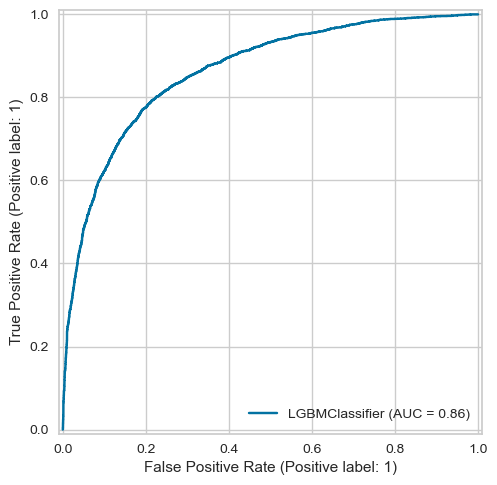

In [17]:
RocCurveDisplay.from_estimator(lgbm_model,X_test,y_test)

In [18]:
# 테스트 세트에 대한 예측
y_pred = lgbm_model.predict(X_test)

In [19]:
# 정확도 계산
accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.8113


In [21]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87      6368
           1       0.75      0.62      0.68      2992

    accuracy                           0.81      9360
   macro avg       0.79      0.76      0.77      9360
weighted avg       0.81      0.81      0.81      9360



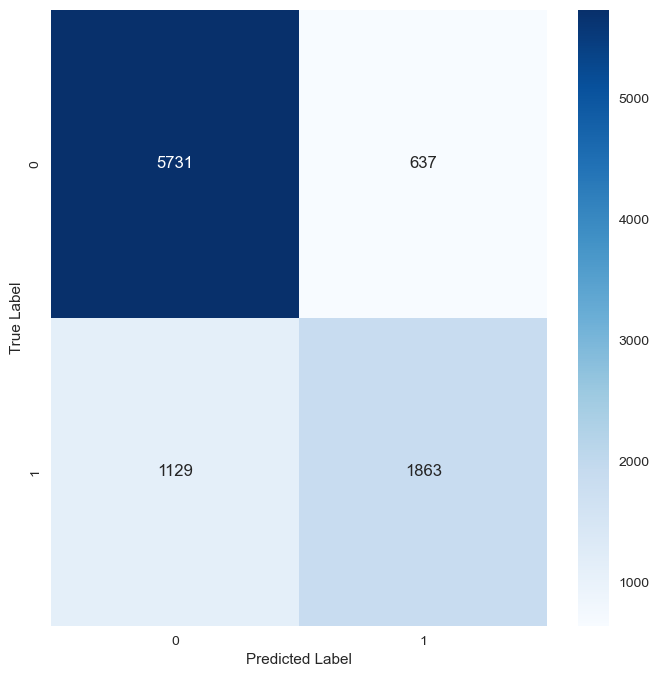

In [23]:
plt.figure(figsize=(8,8))
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### 임곗값 구하기

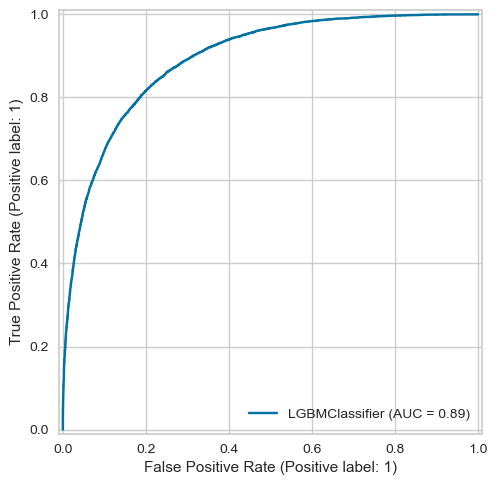

In [52]:
RocCurveDisplay.from_estimator(lgbm_model,X_train,y_train)

In [38]:
fpr, tpr, thresholds = roc_curve(y_train,lgbm_model.predict_proba(X_train)
[:,1],drop_intermediate=False)

In [40]:
i = np.arange(len(tpr))
roc = pd.DataFrame({'fpr' : pd.Series(fpr, index=i),'tpr' : pd.Series(tpr, index = i), '1-fpr' : pd.Series(1-fpr, index = i), 'tf' : pd.Series(tpr - (1-fpr), index = i), 'thresholds' : pd.Series(thresholds, index = i)})
roc.iloc[(roc.tf-0).abs().argsort()[:1]]

,fpr,tpr,1-fpr,tf,thresholds
14602,0.192353,0.807641,0.807647,-0.000006,0.325006


[Text(-5000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5000.0, 0, ''),
 Text(10000.0, 0, ''),
 Text(15000.0, 0, ''),
 Text(20000.0, 0, ''),
 Text(25000.0, 0, ''),
 Text(30000.0, 0, ''),
 Text(35000.0, 0, ''),
 Text(40000.0, 0, '')]

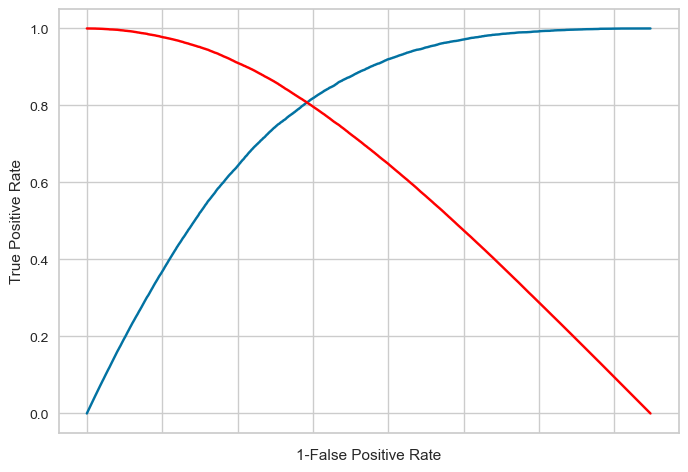

In [42]:

fig, ax = plt.subplots()
plt.plot(roc['tpr'])
plt.plot(roc['1-fpr'], color = 'red')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
ax.set_xticklabels([])

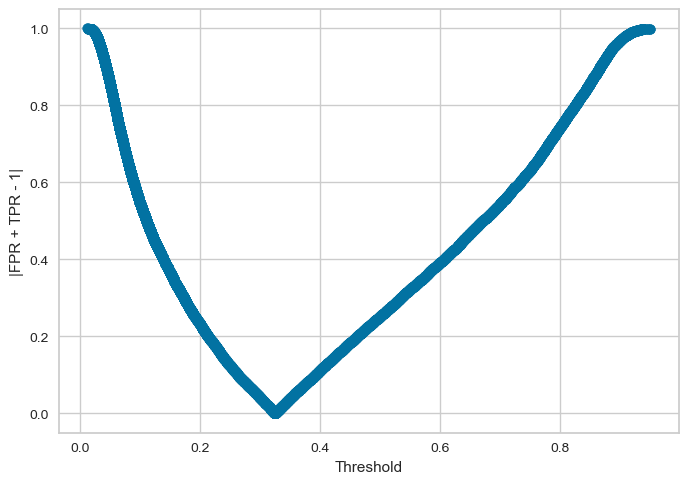

In [43]:
plt.scatter(thresholds,np.abs(fpr+tpr-1))
plt.xlabel("Threshold")
plt.ylabel("|FPR + TPR - 1|")
plt.show()

In [44]:
print('Optimal Threshold: %.16f'%(thresholds[np.argmin(np.abs(fpr+tpr-1))]))

Optimal Threshold: 0.3250060429755484


In [55]:
lgbm_model.fit(X_train,y_train)
threshold = []
accuracy = []
for p in np.unique(lgbm_model.predict_proba(X_train)[:,1]):
    threshold.append(p)
    y_pred = (lgbm_model.predict_proba(X_train)[:,1] >= p).astype(int)
    accuracy.append(balanced_accuracy_score(y_train,y_pred))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12040, number of negative: 25396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004660 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 37436, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321616 -> initscore=-0.746357
[LightGBM] [Info] Start training from score -0.746357


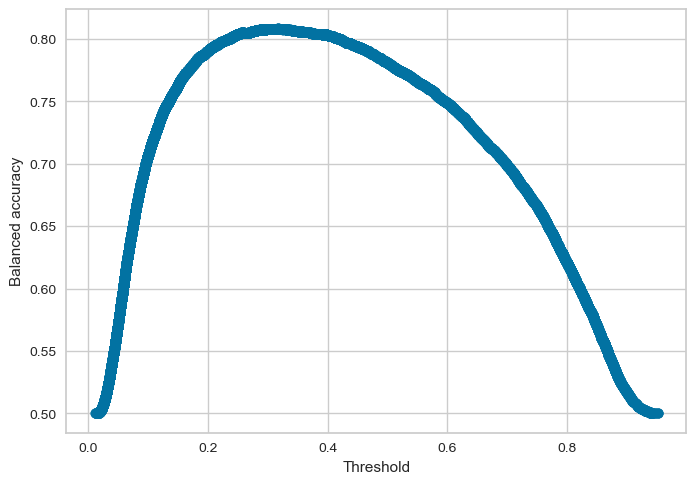

In [56]:
plt.scatter(threshold,accuracy)
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()


In [57]:
threshold[np.argmax(accuracy)]

0.316581141508869

In [24]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12040, number of negative: 25396
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2390
[LightGBM] [Info] Number of data points in the train set: 37436, number of used features: 126
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.321616 -> initscore=-0.746357
[LightGBM] [Info] Start training from score -0.746357


LGBMClassifier(n_jobs=-1, random_state=123)

In [25]:
y_pred_prob = pred_proba = lgbm_model.predict_proba(X_test)[:, 1]

In [26]:
y_pred_prob

array([0.53989942, 0.07616121, 0.04583446, ..., 0.60979235, 0.69135105,
       0.62275574])

In [27]:
# 임곗값 0.316581141508869 적용
threshold = 0.316581141508869
y_pred = (y_pred_prob >= threshold).astype(int)

In [28]:
print('\nClassification Report:')
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84      6368
           1       0.64      0.78      0.70      2992

    accuracy                           0.79      9360
   macro avg       0.76      0.79      0.77      9360
weighted avg       0.81      0.79      0.80      9360



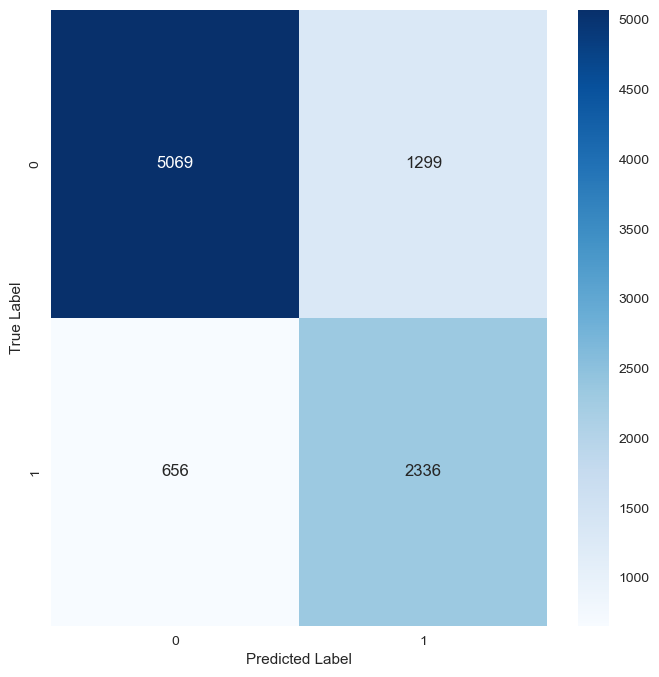

In [29]:
plt.figure(figsize=(8,8))
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [9]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [10]:
def scheduler_function(epoch, lr):
    if epoch < 5: # epoch 5 동안은 학습률 유지
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1)) # 그 뒤부터 학습률 감소

In [11]:
import os

checkpoint_filepath = os.path.join(os.getcwd(), 'best_model.keras')

In [11]:
callbacks_list = [
    ModelCheckpoint(
        filepath=checkpoint_filepath,
        monitor='val_loss',
        save_best_only=True),
    
     EarlyStopping(
         monitor='val_accuracy', 
         patience=10, mode = 'max',
         restore_best_weights=True),
    
     LearningRateScheduler(scheduler_function)
]

In [12]:
initializer = tf.keras.initializers.HeNormal(seed = 42)

In [13]:
n_features = X.shape[1]

In [14]:
model = Sequential(name = 'tensorflow_model')
# 1) 입력
model.add(Input(shape=(n_features,)))

# 2) 첫 번째 블록
model.add(Dense(255, kernel_initializer=initializer, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# 3) 두 번째 블록
model.add(Dense(125, kernel_initializer=initializer, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# 4) 세 번째 블록
model.add(Dense(61, kernel_initializer=initializer, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

# 5) 네 번째 블록
model.add(Dense(30, kernel_initializer=initializer, use_bias=False))
model.add(BatchNormalization())
model.add(Activation('relu'))
# 필요하다면 Dropout 추가 가능

# 6) 출력
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [15]:
model.summary()

Model: "tensorflow_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 255)               32130     
                                                                 
 batch_normalization (BatchN  (None, 255)              1020      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 255)               0         
                                                                 
 dropout (Dropout)           (None, 255)               0         
                                                                 
 dense_1 (Dense)             (None, 125)               31875     
                                                                 
 batch_normalization_1 (Batc  (None, 125)              500       
 hNormalization)                                  

In [16]:
hist=model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, callbacks=callbacks_list)

Epoch 1/100
878/878 [==============================] - 12s 10ms/step - loss: 0.5316 - accuracy: 0.7461 - val_loss: 0.4799 - val_accuracy: 0.7803 - lr: 0.0010
Epoch 2/100
878/878 [==============================] - 8s 9ms/step - loss: 0.4881 - accuracy: 0.7773 - val_loss: 0.4672 - val_accuracy: 0.7894 - lr: 0.0010
Epoch 3/100
878/878 [==============================] - 8s 10ms/step - loss: 0.4757 - accuracy: 0.7857 - val_loss: 0.4613 - val_accuracy: 0.7934 - lr: 0.0010
Epoch 4/100
878/878 [==============================] - 9s 10ms/step - loss: 0.4702 - accuracy: 0.7872 - val_loss: 0.4594 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 5/100
878/878 [==============================] - 10s 12ms/step - loss: 0.4684 - accuracy: 0.7870 - val_loss: 0.4557 - val_accuracy: 0.7954 - lr: 0.0010
Epoch 6/100
878/878 [==============================] - 10s 11ms/step - loss: 0.4660 - accuracy: 0.7880 - val_loss: 0.4549 - val_accuracy: 0.7963 - lr: 9.0484e-04
Epoch 7/100
878/878 [==============================]

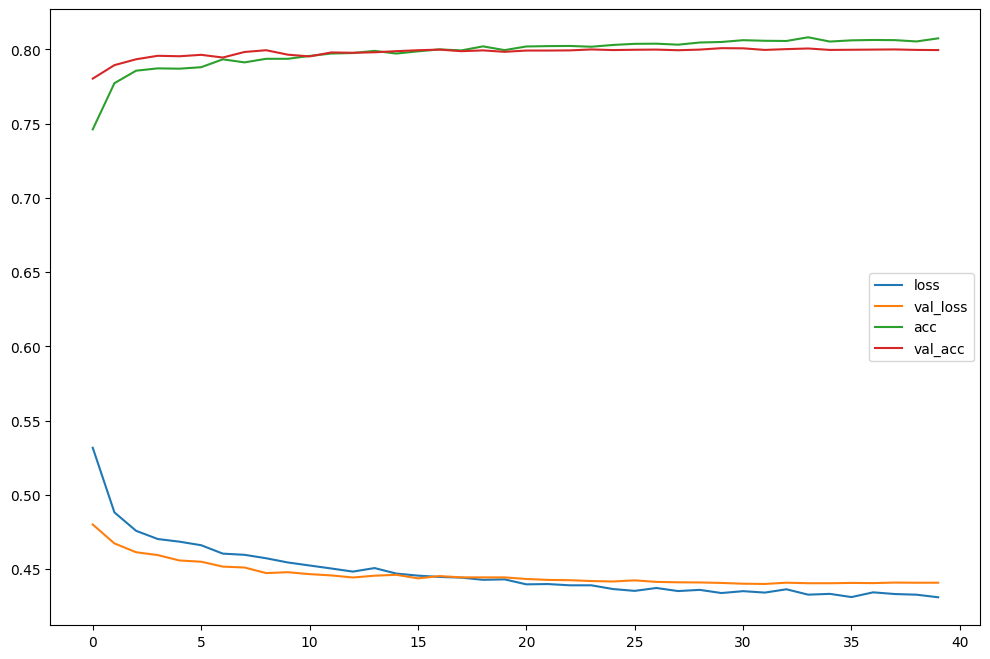

In [19]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['loss','val_loss','acc','val_acc'])
plt.show()

In [23]:
score=model.evaluate(X_test,y_test)
print('%s: %.2f%%' %(model.metrics_names[1],score[1]*100))

293/293 [==============================] - 1s 3ms/step - loss: 0.4291 - accuracy: 0.8079
accuracy: 80.79%


In [24]:
#model.save('best_model.keras')

In [14]:
model2 = keras.models.load_model('best_model.keras')

In [15]:
score=model2.evaluate(X_test,y_test)
print('%s: %.2f%%' %(model2.metrics_names[1],score[1]*100))

293/293 [==============================] - 1s 3ms/step - loss: 0.4291 - accuracy: 0.8079
accuracy: 80.79%


In [17]:
y_pred = model2.predict(X_test)

293/293 [==============================] - 1s 2ms/step


In [18]:
y_pred

array([[0.34184957],
       [0.06992189],
       [0.02502403],
       ...,
       [0.58377194],
       [0.64480376],
       [0.50186545]], dtype=float32)

In [20]:
y_pred = model2.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)  # 0.5를 기준으로 이진 분류

293/293 [==============================] - 1s 2ms/step


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.86      6368
           1       0.74      0.61      0.67      2992

    accuracy                           0.81      9360
   macro avg       0.79      0.76      0.77      9360
weighted avg       0.80      0.81      0.80      9360



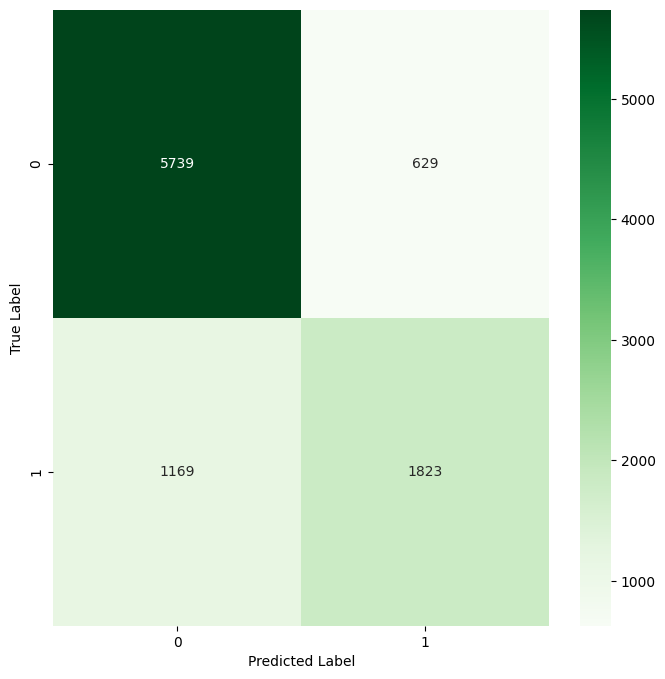

In [23]:
plt.figure(figsize=(8,8))
cm2 = confusion_matrix(y_test, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## 